In [1]:
import pandas as pd
import numpy as np
import argparse
import time
import math
import copy

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem import Crippen
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdchem import GetPeriodicTable
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.ML.Descriptors import MoleculeDescriptors

from mordred import Calculator, descriptors
from padelpy import padeldescriptor, from_smiles

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
#from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import metrics
from sklearn.svm import SVR

import xgboost as xgb

import torch
from torch_geometric.data import Data
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Linear, Sequential, BatchNorm1d #, ReLU
from torch.nn.functional import relu
from torch.utils.data.sampler import SubsetRandomSampler


# Read Data from Files

In [2]:
test_smiles = pd.read_csv('test_smile.csv')

In [3]:
test_smiles

,smiles
0,CCCCCCCCCCC(C)OCCOCCOCCOCCO
1,CCCCCCCCCCSC1OC(=O)C(O)C1O
2,CCCCCCCC[N+](C)(C)CCOCC[N+](C)(C)CCCCCCCC
3,CCCCCCCCCC1COCCC1OS(=O)(=O)[O-]
4,CCCCCCCCCCCC[N+](C)(C)CC(O)CN(CCC)CC(O)C[N+](C...
...,...
83,CCCCCCCCC(=O)OCC(O)C(O)C(O)CO
84,CCCCCCCCCCCCCC[n+]1ccccc1
85,CCCCCCCCCCCCCCCCOCCOCCOCCOCCOCCOCCOCCO
86,CCCCCCCCCCCCOCCOCCOCCOCCOCCOCCOCCOCCO


In [4]:
def calculate_total_charge(smiles):
    mol = Chem.MolFromSmiles(smiles)  
    if mol is None:
        return None  # Return None instead of a string for better error handling
    return Chem.GetFormalCharge(mol)


test_net_charges = [calculate_total_charge(smiles) for smiles in test_smiles['smiles']]

#print("Total Charges:", test_net_charges)


In [5]:
num_positive = np.sum(np.array(test_net_charges) > 0)
num_neutral = np.sum(np.array(test_net_charges) == 0)
num_negative = np.sum(np.array(test_net_charges) < 0)

print(f"Positive charges: {num_positive}")
print(f"Neutral charges: {num_neutral}")
print(f"Negative charges: {num_negative}")

Positive charges: 34
Neutral charges: 43
Negative charges: 11


In [6]:
full_train_rdkit = pd.read_csv('train_rdkit_descriptors.csv')
test_rdkit = pd.read_csv('test_rdkit_descriptors.csv')

full_train_mordred = pd.read_csv('train_mordred_descriptors.csv')
test_mordred = pd.read_csv('test_mordred_descriptors.csv')

full_train_padel = pd.read_csv('train_padel_descriptors.csv')
test_padel = pd.read_csv('test_padel_descriptors.csv')

full_Z_train = pd.read_csv('train_property.csv')
Z_test = pd.read_csv('test_property.csv')



In [7]:
Z_test

,logCMC
0,1.795998
1,1.518514
2,4.324000
3,4.471125
4,2.795000
...,...
83,3.643453
84,3.544068
85,0.230449
86,2.037426


In [8]:
full_train_rdkit=np.array(full_train_rdkit)
test_rdkit=np.array(test_rdkit)

full_train_mordred=np.array(full_train_mordred)
test_mordred=np.array(test_mordred)

full_train_padel=np.array(full_train_padel)
test_padel=np.array(test_padel)


In [9]:
train_rdkit, valida_rdkit, train_mordred, valida_mordred, train_padel, valida_padel, Z_train, Z_valida = train_test_split(
    full_train_rdkit, full_train_mordred, full_train_padel, full_Z_train, test_size=0.1, random_state=142)

In [10]:
Z_train = np.array(Z_train) 
Z_valida = np.array(Z_valida) 
Z_test = np.array(Z_test)

Z_train = Z_train.ravel()
Z_valida = Z_valida.ravel()
Z_test = Z_test.ravel()

In [11]:
Z_train.shape, Z_valida.shape, Z_test.shape

((316,), (36,), (88,))

### Define the ANN model using PyTorch.

In [12]:
# Define the ANN model using PyTorch.

class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super(ANNModel, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer to first hidden layer
        self.layers.append(nn.Linear(input_dim, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        
        # Adding subsequent hidden layers
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
        
        # Last hidden layer to output layer
        self.layers.append(nn.Linear(hidden_layers[-1], 1))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


### RDKit Neural Network

In [13]:
train_nn_rdkit = torch.tensor(train_rdkit, dtype=torch.float32)
Z_train_nn = torch.tensor(Z_train, dtype=torch.float32).view(-1, 1)

valida_nn_rdkit = torch.tensor(valida_rdkit, dtype=torch.float32)
Z_valida_nn = torch.tensor(Z_valida, dtype=torch.float32).view(-1, 1)

test_nn_rdkit = torch.tensor(test_rdkit, dtype=torch.float32)
Z_test_nn = torch.tensor(Z_test, dtype=torch.float32).view(-1, 1)

In [14]:
# Create the dataset and dataloader
train_dataset_rdkit = TensorDataset(train_nn_rdkit, Z_train_nn)
train_loader_rdkit = DataLoader(train_dataset_rdkit, batch_size=32, shuffle=False)

valida_dataset_rdkit = TensorDataset(valida_nn_rdkit, Z_valida_nn)
valida_loader_rdkit = DataLoader(valida_dataset_rdkit, batch_size=32, shuffle=False)

test_dataset_rdkit = TensorDataset(test_nn_rdkit, Z_test_nn)
test_loader_rdkit = DataLoader(test_dataset_rdkit, batch_size=32, shuffle=False)

In [15]:
# Parameters

input_dim_rdkit = train_nn_rdkit.shape[1]
hidden_layers_rdkit = [256, 128, 64, 32] #, 96, 64, 32]
num_epochs_rdkit = 1050
batch_size_rdkit =32
learning_rate_rdkit = 0.0001
#train_nn_rdkit is a DataFrame or NumPy array with shape (num_samples, num_features)


In [16]:
# Create an instance of the ANN model
model_rdkit = ANNModel(input_dim_rdkit,hidden_layers_rdkit)

#Define the Loss Function and Optimizer:
criterion = nn.MSELoss()  # Mean Squared Error for regression tasks
optimizer = optim.Adam(model_rdkit.parameters(), lr=learning_rate_rdkit)

In [17]:
# Train the Model:
rdkit_training_loss=[]
rdkit_validation_loss=[]

for epoch in range(num_epochs_rdkit):
    model_rdkit.train()
    for X_batch, y_batch in train_loader_rdkit:
        # Forward pass
        outputs = model_rdkit(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    for X_val_batch, y_val_batch in valida_loader_rdkit:
        # Forward pass
        outputs = model_rdkit(X_val_batch)
        val_loss = criterion(outputs, y_val_batch)

    # Print loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs_rdkit}], train_Loss: {loss.item():.4f}, valida_Loss: {val_loss.item():.4f}')
    # Append the losses
    rdkit_training_loss.append(loss.item())
    rdkit_validation_loss.append(val_loss.item())

Epoch [1/1050], train_Loss: 9.1499, valida_Loss: 7.0704
Epoch [2/1050], train_Loss: 8.9559, valida_Loss: 6.8682
Epoch [3/1050], train_Loss: 8.6813, valida_Loss: 6.5876
Epoch [4/1050], train_Loss: 8.2752, valida_Loss: 6.1623
Epoch [5/1050], train_Loss: 7.6499, valida_Loss: 5.5149
Epoch [6/1050], train_Loss: 6.7457, valida_Loss: 4.5768
Epoch [7/1050], train_Loss: 5.5089, valida_Loss: 3.3000
Epoch [8/1050], train_Loss: 4.0776, valida_Loss: 1.8404
Epoch [9/1050], train_Loss: 2.8724, valida_Loss: 0.6133
Epoch [10/1050], train_Loss: 2.3807, valida_Loss: 0.1160
Epoch [11/1050], train_Loss: 2.3280, valida_Loss: 0.1056
Epoch [12/1050], train_Loss: 2.1976, valida_Loss: 0.1029
Epoch [13/1050], train_Loss: 2.0790, valida_Loss: 0.1150
Epoch [14/1050], train_Loss: 1.9828, valida_Loss: 0.1232
Epoch [15/1050], train_Loss: 1.8886, valida_Loss: 0.1278
Epoch [16/1050], train_Loss: 1.7962, valida_Loss: 0.1386
Epoch [17/1050], train_Loss: 1.7003, valida_Loss: 0.1520
Epoch [18/1050], train_Loss: 1.6029, val

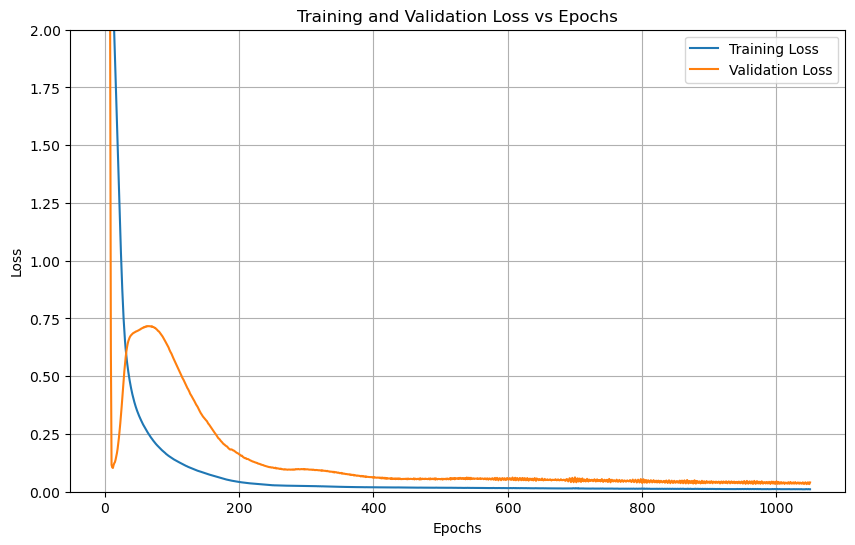

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs_rdkit + 1), rdkit_training_loss, label='Training Loss')
plt.plot(range(1, num_epochs_rdkit + 1), rdkit_validation_loss, label='Validation Loss')
#plt.xlim([0, 7])
plt.ylim([0, 2.0])
# Adding titles and labels
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Evaluate the Model:

model_rdkit.eval()
with torch.no_grad():
    Z_pred_train_rdkit = model_rdkit(train_nn_rdkit)
    train_loss_rdkit = criterion(Z_pred_train_rdkit, Z_train_nn).item()

    Z_pred_valida_rdkit = model_rdkit(valida_nn_rdkit)
    valida_loss_rdkit = criterion(Z_pred_valida_rdkit, Z_valida_nn).item()

    Z_pred_test_rdkit = model_rdkit(test_nn_rdkit)
    test_loss_rdkit = criterion(Z_pred_test_rdkit, Z_test_nn).item()
    # Convert predictions and true values to NumPy arrays
    Z_pred_test_rdkit_np = Z_pred_test_rdkit.cpu().numpy()  # If using GPU, move to CPU
    Z_test_nn_np = Z_test_nn.cpu().numpy()  # If using GPU, move to CPU

    # Calculate the R² score
    r2 = r2_score(Z_test_nn_np, Z_pred_test_rdkit_np)
    print('Coefficient of determination (R²):', r2)

print(f'Training Loss: {train_loss_rdkit:.4f}')
print(f'Validation Loss: {valida_loss_rdkit:.4f}')
print(f'Test Loss: {test_loss_rdkit:.4f}')

Coefficient of determination (R²): 0.9083982750454276
Training Loss: 0.0151
Validation Loss: 0.2777
Test Loss: 0.1361


In [36]:
# Create DataFrame
data_parity_plot_ANN_RDKit = pd.DataFrame({
    'Z_test': Z_test_nn.numpy().flatten(),
    'Z_predicted': Z_pred_test_rdkit.numpy().flatten(),
    'Total_Charge': np.array(test_net_charges).flatten()  # Assuming test_net_charges is already a list
})

# Save to CSV
data_parity_plot_ANN_RDKit.to_csv('data_parity_plot_ANN_RDKit.csv', index=False)

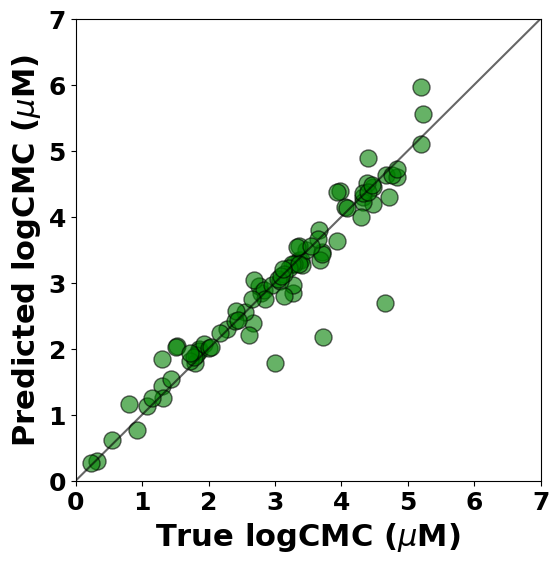

In [20]:
label_fs = 24
ticks_fs = 18
marker_s=150
ap = 0.6

plt.rcParams["figure.figsize"] = (6, 6)
plt.scatter(Z_test_nn.numpy(), Z_pred_test_rdkit.numpy(),s=marker_s, alpha=ap, color='Green', edgecolor='black') 
plt.plot([0,7], [0,7], alpha=ap, color='black')
plt.xlim([0, 7])
plt.ylim([0, 7])
plt.xlabel(r'True logCMC ($\mu$M)', fontsize=22, fontweight='bold')
plt.ylabel('Predicted logCMC ($\mu$M)', fontsize=22, fontweight='bold')
plt.xticks(fontsize=ticks_fs,fontweight='bold')
plt.yticks(fontsize=ticks_fs,fontweight='bold')

plt.savefig('ANN-RDKit.png', bbox_inches='tight')
plt.show()

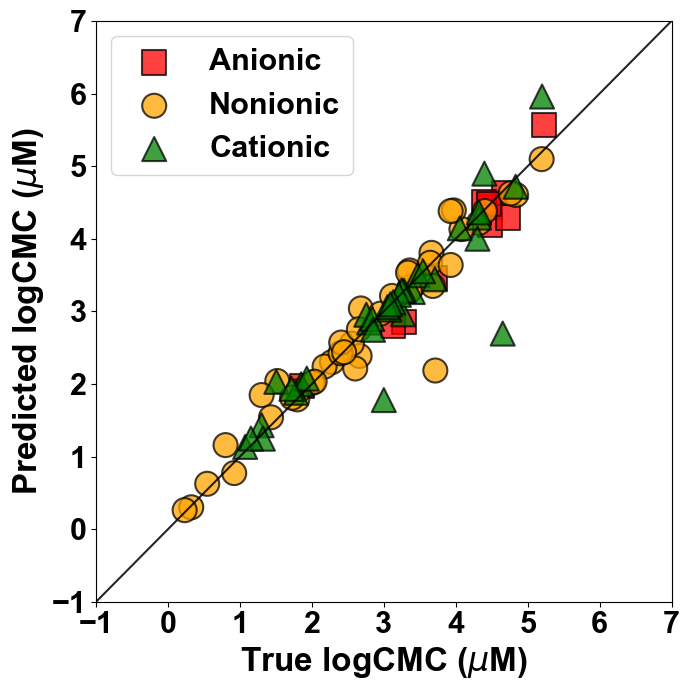

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Define charge categories
# Define charge categories and corresponding markers
charge_categories = []
charge_markers = []  # New list to store marker types

for charge in test_net_charges:
    if charge < 0:
        charge_categories.append('anionic')
        charge_markers.append('s')  # Square marker for negative charge
    elif charge == 0:
        charge_categories.append('nonionic')
        charge_markers.append('o')  # Circle marker for neutral charge
    else:
        charge_categories.append('cationic')
        charge_markers.append('^')  # Triangle marker for positive charge

# Color mapping
charge_colors = {
    "anionic": "red",
    "nonionic": "orange",
    "cationic": "green"
}

color_list = [charge_colors[cat] for cat in charge_categories]

plt.figure(figsize=(7, 7))

# Plot each category separately with appropriate marker type
for category, marker in zip(["anionic", "nonionic", "cationic"], ['s', 'o', '^']):
    indices = [i for i, cat in enumerate(charge_categories) if cat == category]
    plt.scatter(
        np.array(Z_test_nn)[indices], np.array(Z_pred_test_rdkit)[indices],
        c=[charge_colors[category]] * len(indices),
        s=300,
        marker=marker,
        edgecolor='k',
        linewidths=1.5,
        alpha=0.75,
        label=f"{category.capitalize()}"
    )

# Parity reference line
plt.plot([-1, 7], [-1, 7], alpha=0.85, color='black', linewidth='1.5')

plt.xlim([-1, 7])
plt.ylim([-1, 7])
plt.xlabel(r'True logCMC ($\mu$M)', fontsize=24, fontname='Arial', fontweight='bold')
plt.ylabel('Predicted logCMC ($\mu$M)', fontsize=24, fontname='Arial', fontweight='bold')
plt.xticks(fontsize=22,fontname='Arial',fontweight='bold')
plt.yticks(fontsize=22,fontname='Arial',fontweight='bold')

# # Custom legend
# legend_handles = [
#     mpatches.Patch(color='blue', label='Negative charge'),
#     mpatches.Patch(color='green', label='Neutral charge'),
#     mpatches.Patch(color='red', label='Positive charge'),
# ]

plt.legend(prop={'size': 22, 'weight': 'bold', 'family': 'Arial'}, loc='upper left', frameon=True)


#plt.title('This Work: ANN + RDKit', fontsize=20, fontweight='bold')

#plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('ANN-RDKit.png', dpi=600, bbox_inches='tight')
plt.show()


In [56]:
import pandas as pd

# Flatten the arrays to ensure they are 1D
file_Z_test_nn = np.ravel(Z_test_nn)  # Converts (88,1) to (88,)
file_Z_pred_test_rdkit = np.ravel(Z_pred_test_rdkit)  # Converts (88,1) to (88,)

# Create a DataFrame with true values, predicted values, and charge categories
data_to_save = pd.DataFrame({
    'True Value': file_Z_test_nn,  # Actual values
    'Predicted Value': file_Z_pred_test_rdkit,  # Model predictions
    'Charge Category': charge_categories  # Charge classifications
})

# Save to CSV file
data_to_save.to_csv('test_data_predicted_with_charge_category.csv', index=False)

print("Data saved successfully to 'true_predicted_charge.csv'")


Data saved successfully to 'true_predicted_charge.csv'


In [51]:
rdkit_descr_name=pd.read_csv('train_rdkit_descriptors.csv')
rdkit_descr_name=rdkit_descr_name.columns
rdkit_descr_name

Index(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=210)

In [23]:
def feature_importance(model, X, feature_names, top_n=10):
    importance = []

    for i in range(X.shape[1]):
        permuted_X = X.clone().detach().numpy()  # Convert tensor to NumPy array
        np.random.shuffle(permuted_X[:, i])
        permuted_X_tensor = torch.tensor(permuted_X, dtype=torch.float32)
        permuted_outputs = model(permuted_X_tensor).detach().numpy()
        original_outputs = model(X.clone().detach()).detach().numpy()  # Create a copy of X
        importance.append(np.mean(np.abs(original_outputs - permuted_outputs)))

    # Sort the features based on importance and print the top N
    sorted_indices = np.argsort(importance)[::-1]
    top_features = [(feature_names[i], importance[i]) for i in sorted_indices[:top_n]]
    for name, imp in top_features:
        print(f"{name}: {imp}")

    return importance


# Calculate feature importance
mordred_importance = feature_importance(model_rdkit, train_nn_rdkit,rdkit_descr_name)


#print("Feature Importance:", importance)

VSA_EState7: 0.4129437804222107
PEOE_VSA6: 0.3231801688671112
MolLogP: 0.30500414967536926
BCUT2D_MRLOW: 0.2460709512233734
fr_quatN: 0.23241299390792847
SMR_VSA5: 0.22567908465862274
SlogP_VSA5: 0.2175082415342331
VSA_EState8: 0.20129576325416565
PEOE_VSA3: 0.1804315596818924
NumAromaticRings: 0.13554495573043823


In [24]:
relative_deviation_rdkit_test = ((Z_test_nn.numpy()-Z_pred_test_rdkit.numpy())/Z_test_nn.numpy())*100
relative_deviation_rdkit_train = ((Z_train_nn.numpy()-Z_pred_train_rdkit.numpy())/Z_train_nn.numpy())*100
relative_deviation_rdkit_valida = ((Z_valida_nn.numpy()-Z_pred_valida_rdkit.numpy())/Z_valida_nn.numpy())*100

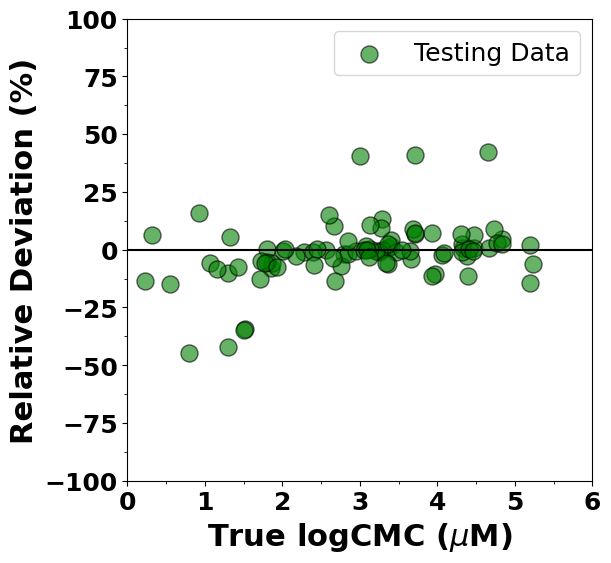

In [25]:
label_fs = 24
ticks_fs = 18
marker_s=150
ap = 0.6
plt.rc('legend', fontsize=18)    # legend fontsize

plt.rcParams["figure.figsize"] = (6, 6)
#plt.scatter(Z_train_nn.numpy(),relative_deviation_rdkit_train,s=marker_s, alpha=ap, color='magenta', edgecolor='black', label="Training Data") 
#plt.scatter(Z_valida_nn.numpy(),relative_deviation_rdkit_valida,s=marker_s, alpha=ap, color='magenta', edgecolor='black') 
plt.scatter(Z_test_nn.numpy(),relative_deviation_rdkit_test,s=marker_s, alpha=ap, color='green', edgecolor='black',label="Testing Data")

#plt.plot([0,6], [0,6], alpha=ap, color='red')
plt.xlim([0, 6])
plt.ylim([-100, 100])
plt.xlabel('True logCMC ($\mu$M)', fontsize=22, fontweight='bold')
plt.ylabel('Relative Deviation (%)', fontsize=22, fontweight='bold')

plt.xticks(fontsize=ticks_fs,fontweight='bold')
plt.yticks(fontsize=ticks_fs,fontweight='bold')
# Add minor ticks on the x-axis
plt.yticks(np.arange(-100, 100.1, 25))
plt.minorticks_on()
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.5))
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(12.5))
plt.axhline(y=0, color='black', linestyle='-')
#
plt.legend()
plt.show()

In [66]:
from sklearn.metrics import mean_absolute_error

# Convert tensors to numpy arrays if not already
y_true_for_MAE = Z_test_nn.numpy()
y_pred_for_MAE = Z_pred_test_rdkit.numpy()

mae = mean_absolute_error(y_true_for_MAE, y_pred_for_MAE)
print("Mean Absolute Error (MAE):", mae)

# Avoid division by zero
mape = np.mean(np.abs((y_true_for_MAE - y_pred_for_MAE) / y_true_for_MAE)) * 100
print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))

# Convert log10(CMC) back to CMC
linear_CMC_true = 10 ** y_true_for_MAE
linear_CMC_pred = 10 ** y_pred_for_MAE

# Compute MAE in linear CMC space
linear_cmc_mae = np.mean(np.abs(linear_CMC_true - linear_CMC_pred))
print("Mean Absolute Error (Linear CMC):", linear_cmc_mae)

# Avoid division by zero
linear_mape = np.mean(np.abs((linear_CMC_true - linear_CMC_pred) / linear_CMC_true)) * 100
print("Mean Absolute Percentage Error (MAPE for linear CMC): {:.2f}%".format(linear_mape))

Mean Absolute Error (MAE): 0.20570031
Mean Absolute Percentage Error (MAPE): 7.81%
Mean Absolute Error (Linear CMC): 14590.069
Mean Absolute Percentage Error (MAPE for linear CMC): 47.81%


In [26]:
train_nn_mordred = torch.tensor(train_mordred, dtype=torch.float32)
Z_train_nn = torch.tensor(Z_train, dtype=torch.float32).view(-1, 1)

valida_nn_mordred = torch.tensor(valida_mordred, dtype=torch.float32)
Z_valida_nn = torch.tensor(Z_valida, dtype=torch.float32).view(-1, 1)

test_nn_mordred = torch.tensor(test_mordred, dtype=torch.float32)
Z_test_nn = torch.tensor(Z_test, dtype=torch.float32).view(-1, 1)

In [27]:
# Create the dataset and dataloader
train_dataset_mordred = TensorDataset(train_nn_mordred, Z_train_nn)
train_loader_mordred = DataLoader(train_dataset_mordred, batch_size=32, shuffle=False)

valida_dataset_mordred = TensorDataset(valida_nn_mordred, Z_valida_nn)
valida_loader_mordred = DataLoader(valida_dataset_mordred, batch_size=32, shuffle=False)

test_dataset_mordred = TensorDataset(test_nn_mordred, Z_test_nn)
test_loader_mordred = DataLoader(test_dataset_mordred, batch_size=32, shuffle=False)

In [28]:
# Parameters

input_dim_mordred = train_nn_mordred.shape[1]
hidden_layers_mordred = [512, 256, 128, 64] #, 64, 32]
num_epochs_mordred = 800
batch_size_mordred = 320
learning_rate_mordred = 0.00005
#train_nn_rdkit is a DataFrame or NumPy array with shape (num_samples, num_features)

In [29]:
# Create an instance of the ANN model
model_mordred = ANNModel(input_dim_mordred,hidden_layers_mordred)

#Define the Loss Function and Optimizer:
criterion = nn.MSELoss()  # Mean Squared Error for regression tasks
optimizer = optim.Adam(model_mordred.parameters(), lr=learning_rate_mordred)

In [30]:
# Train the Model:
mordred_training_loss=[]
mordred_validation_loss=[]

for epoch in range(num_epochs_mordred):
    model_mordred.train()
    for X_batch, y_batch in train_loader_mordred:
        # Forward pass
        outputs = model_mordred(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for X_val_batch_mord, y_val_batch_mord in valida_loader_mordred:
        # Forward pass
        outputs = model_mordred(X_val_batch_mord)
        val_loss_mord = criterion(outputs, y_val_batch_mord)
        
    # Print loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs_mordred}], train_Loss: {loss.item():.4f}, valida_Loss: {val_loss_mord.item():.4f}')
    # Append the losses
    mordred_training_loss.append(loss.item())
    mordred_validation_loss.append(val_loss_mord.item())

Epoch [1/800], train_Loss: 10.2057, valida_Loss: 8.0311
Epoch [2/800], train_Loss: 9.7867, valida_Loss: 7.5923
Epoch [3/800], train_Loss: 9.0917, valida_Loss: 6.8619
Epoch [4/800], train_Loss: 7.9546, valida_Loss: 5.6778
Epoch [5/800], train_Loss: 6.2634, valida_Loss: 3.9510
Epoch [6/800], train_Loss: 4.1847, valida_Loss: 1.9302
Epoch [7/800], train_Loss: 2.4192, valida_Loss: 0.4082
Epoch [8/800], train_Loss: 1.8479, valida_Loss: 0.1957
Epoch [9/800], train_Loss: 1.8410, valida_Loss: 0.3073
Epoch [10/800], train_Loss: 1.6931, valida_Loss: 0.1723
Epoch [11/800], train_Loss: 1.6159, valida_Loss: 0.1348
Epoch [12/800], train_Loss: 1.5330, valida_Loss: 0.1430
Epoch [13/800], train_Loss: 1.4479, valida_Loss: 0.1685
Epoch [14/800], train_Loss: 1.3654, valida_Loss: 0.1800
Epoch [15/800], train_Loss: 1.2810, valida_Loss: 0.1800
Epoch [16/800], train_Loss: 1.1966, valida_Loss: 0.1872
Epoch [17/800], train_Loss: 1.1122, valida_Loss: 0.2020
Epoch [18/800], train_Loss: 1.0287, valida_Loss: 0.2168


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs_mordred + 1), mordred_training_loss, label='Training Loss')
plt.plot(range(1, num_epochs_mordred + 1), mordred_validation_loss, label='Validation Loss')
#plt.xlim([0, 7])
plt.ylim([0, 2.0])
# Adding titles and labels
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the Model:

model_mordred.eval()
with torch.no_grad():
    Z_pred_train_mordred = model_mordred(train_nn_mordred)
    train_loss_mordred = criterion(Z_pred_train_mordred, Z_train_nn).item()

    Z_pred_test_mordred = model_mordred(test_nn_mordred)
    test_loss_mordred = criterion(Z_pred_test_mordred, Z_test_nn).item()

print(f'Training Loss: {train_loss_mordred:.4f}')
print(f'Test Loss: {test_loss_mordred:.4f}')

In [ ]:
label_fs = 24
ticks_fs = 18
marker_s=80
ap = 0.4

plt.rcParams["figure.figsize"] = (6, 6)
plt.scatter(Z_test_nn.numpy(), Z_pred_test_mordred.numpy(),s=marker_s, alpha=ap, color='Blue', edgecolor='black') 
plt.plot([0,7], [0,7], alpha=ap, color='red')
plt.xlim([0, 6])
plt.ylim([0, 6])
plt.xlabel('True logCMC (mM)', fontsize=label_fs)
plt.ylabel('Predicted logCMC (mM)', fontsize=label_fs)
plt.xticks(fontsize=ticks_fs)
plt.yticks(fontsize=ticks_fs)
plt.show()

In [ ]:
mordred_descr_name=pd.read_csv('train_mordred_descriptors.csv')
mordred_descr_name=mordred_descr_name.columns
mordred_descr_name

In [ ]:
def feature_importance(model, X, feature_names, top_n=10):
    importance = []

    for i in range(X.shape[1]):
        permuted_X = X.clone().detach().numpy()  # Convert tensor to NumPy array
        np.random.shuffle(permuted_X[:, i])
        permuted_X_tensor = torch.tensor(permuted_X, dtype=torch.float32)
        permuted_outputs = model(permuted_X_tensor).detach().numpy()
        original_outputs = model(X.clone().detach()).detach().numpy()  # Create a copy of X
        importance.append(np.mean(np.abs(original_outputs - permuted_outputs)))

    # Sort the features based on importance and print the top N
    sorted_indices = np.argsort(importance)[::-1]
    top_features = [(feature_names[i], importance[i]) for i in sorted_indices[:top_n]]
    for name, imp in top_features:
        print(f"{name}: {imp}")

    return importance


# Calculate feature importance
mordred_importance = feature_importance(model_mordred, train_nn_mordred,mordred_descr_name)


#print("Feature Importance:", importance)